<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Automatically classify consumer goods - P6</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
## General
import ast
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid")

## Scikit Learn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Own specific functions 
from functions_eda import *
from functions_nlp import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files and Initial analysis</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to load the dateset resulting from the RFM
</div>

In [2]:
data = pd.read_csv(r"datasets\flipkart_com-ecommerce_sample_1050.csv")

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Initial analysis</h3>
</div>

In [4]:
df_analysis(data, "data", columns=["uniq_id"], analysis_type="complete")


Analysis Header of data dataset
--------------------------------------------------------------------------------
- Dataset shape:			 1050 rows and 15 columns
- Total of NaN values:			 341
- Percentage of NaN:			 2.17 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 116.0+ KB

- The key(s):	 ['uniq_id'] is not present multiple times in the dataframe. 
		 It CAN be used as a primary key.

Detailed analysis of data dataset
------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,uniq_id,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,crawl_timestamp,object,1050,149,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_url,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,product_name,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,product_category_tree,object,1050,642,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,pid,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,image,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,is_FK_Advantage_product,bool,1050,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,description,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,product_rating,object,1050,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    <p>Plotting the percentage of missing values by features</p>
</div>

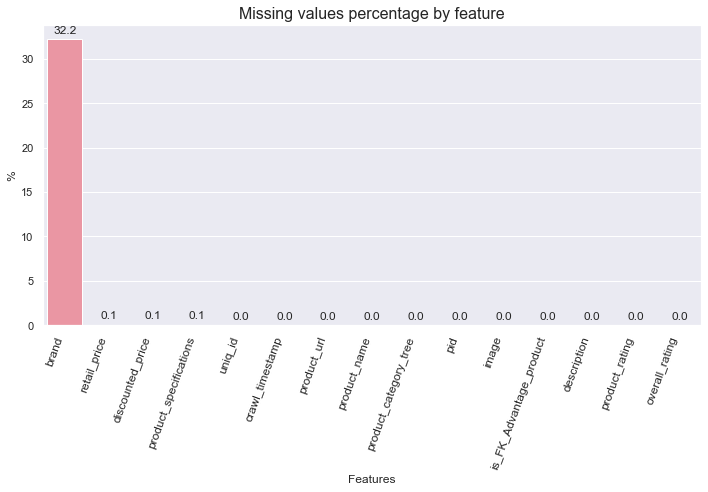

In [5]:
missing_values = data.isnull().sum(axis=0).sort_values(ascending=False)/len(data.index)*100

fig = plt.figure(figsize=(10, 7))
plot = sns.barplot(x=missing_values.index.tolist(), y=missing_values.values.tolist())
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plot.set_xticklabels(labels=missing_values.index.tolist(), rotation=70, size=12, horizontalalignment="right")
plt.ylabel("%", size=12)
plt.xlabel("Features", size=12)
plt.title("Missing values percentage by feature", size=16)
plt.tight_layout()
plt.savefig("images/text_analysis/missing-values-percentage-by-feature.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul>
        <li>There are some features that are not important to our text analysis. For example, pid, uniq_id, etc.</li>
        <li>The missing value percentage is higher only in one feature.</li>
    </ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Selecting the features to work</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Analyzing the features</h3>
</div>

In [6]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [7]:
data.tail(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-sticker/p/itme2zepqqzr9jt5?pid=STIE2ZEPACRQJKH7,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >> Uberlyfe Stickers""]",STIE2ZEPACRQJKH7,1190.00000,595.00000,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Package"", ""value""=>""Sticker""}, {""key""=>""Brand"", ""value""=>""Uberlyfe""}, {""key""=>""Type"", ""value""=>""Vinyl""}, {""key""=>""Number of Stickers"", ""value""=>""1""}, {""key""=>""Size"", ""value""=>""Large""}]}"


In [8]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div class="alert alert-block alert-info">
    <p>Let's analyze in detail the feature <b>brand</b></p>
</div>

In [9]:
data["brand"].unique()

array(['Elegance', 'Sathiyas', 'Eurospa', 'SANTOSH ROYAL FASHION',
       'Jaipur Print', nan, 'House This', 'Riva Carpets', 'Myesquire',
       'Dungri India Craft', 'BFT', 'JMD', 'Mom and Kid', "Kripa's",
       'Burt s Bees', 'AKUP', 'D-Link', 'Suave', 'RoQ', 'Cookart', 'JRB',
       'RYTHMX', 'Brillare Science', 'Mars', 'Aroma Care', 'KOHL',
       'Shopmania', 'CHHOTE JANAB', 'Prime', 'SKI', 'GAYATRI CREATIONS',
       'Caffeine', 'Garnet', 'Vitamins', 'KE', 'Giorgio Armani',
       'florence9', 'VarEesha', 'Treasure', 'CHINMAY KIDS', 'HEAVENLY',
       '@home', 'Smart Wall Guru', 'oxford', 'Eureka.in', 'Craft Trade',
       'Parv Collections', 'Exotic India', 'Aapno Rajasthan',
       'BeYOUtiful', 'My Angel', 'Diviniti', 'K&P', 'Rama',
       'Shop Rajasthan', 'Bestway', 'Artisan Creation', 'Remtex Export',
       'TWISHA', 'Eternity', 'FS Mini Klub', 'Omic', 'Filink', 'Recrafto',
       'FRENEMY', 'Quilt India', 'Toffyhouse', 'Shopizone', 'Craftcart',
       'SOS', 'Arsalan', '

<div class="alert alert-block alert-warning">
    <p>It seems that it does not add value to the problem. It contains the names of brands and probably it does not add value to classify images</p>
    <p>Despite that, we are going to keep it</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Selecting the features</h3>
</div>

<div class="alert alert-block alert-warning">
    <p>To select the features, first, we are going to <b>discard features</b> that do not add value to the problem</p>
    <ul style="list-style-type: square;">
        <li><b>crawl_timestamp</b></li>
        <li><b>product_url</b></li>
        <li><b>pid</b></li>
        <li><b>is_FK_Advantage_product</b></li>
        <li><b>product_rating</b></li>
        <li><b>overall_rating</b></li>
        <li><b>discounted_price</b></li>
    </ul> 
</div>

In [10]:
df_data = data.drop(columns=["crawl_timestamp", "product_url", "pid", "is_FK_Advantage_product",
                             "product_rating", "overall_rating", "discounted_price"],
                    axis=0).copy()

<div class="alert alert-block alert-info">
    <p>For now, we are going to keep the following features</p>
    <ul style="list-style-type: square;">
        <li><b>uniq_id</b> - we can use this feature to keep relations on the data</li>
        <li><b>product_name</b></li>
        <li><b>product_category_tree</b></li>
        <li><b>description</b></li>
        <li><b>retail_price</b></li>
        <li><b>brand</b></li>
        <li><b>product_specifications</b></li>        
    </ul> 
</div>

In [11]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [12]:
df_data.head(1)

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",1899.00000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"


In [13]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

In [14]:
df_analysis(df_data, "df_data", type_analysis="complete")


Analysis Header of df_data dataset
--------------------------------------------------------------------------------
- Dataset shape:			 1050 rows and 8 columns
- Total of NaN values:			 340
- Percentage of NaN:			 4.05 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 65.8+ KB

Detailed analysis of df_data dataset
------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,uniq_id,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,product_name,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_category_tree,object,1050,642,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,image,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,description,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,retail_price,float64,1049,354,1,0.10000,2186.19733,35.00000,555.00000,999.00000,1999.00000,201000.00000,7639.22941
7,product_specifications,object,1049,984,1,0.10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,brand,object,712,490,338,32.19000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Now, we have a dataset with the following characteristic</p>
    <ul style="list-style-type: square;">
        <li>30% missing-values in <b>brand</b></li>
        <li>One cell with missing-value in <b>retail_price</b></li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Treating missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    <p><b>To treat missing-values</b>, we are going to do as follows</p>
    <ol>
        <li>Fill missing-vallues in <b>brand</b> and <b>product_specifications</b> with empty-value.</li>
        <li>Fill missing-vallues in <b>retail_price</b> based on the median for the same <b>product category</b>.</li>
    </ol>
</div>
<div class="alert alert-block alert-info">
    <p>So, Being the feature called <b>brand</b> only one missing-value, let's proceed to complete it with empty-value</p>
</div>

In [15]:
df_data["brand"].fillna("", inplace=True)
df_data["product_specifications"].fillna("", inplace=True)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Analyzing "product_category_tree"</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's analyse the levels of the tree in <b>product_category_tree</b></p>
</div>

In [16]:
for i in [0, 10, 100, 1049]:
    print(df_data.loc[i, "product_category_tree"])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
["Watches >> Wrist Watches >> Calibro Wrist Watches"]
["Beauty and Personal Care >> Makeup >> Vanity Boxes >> Goldencollections Vanity Boxes"]
["Baby Care >> Baby & Kids Gifts >> Stickers >> Uberlyfe Stickers"]


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>The levels in the tree does not seem equals in all records</p>
</div>

In [17]:
df_data["tree_levels"] = df_data["product_category_tree"].str.count(">>")

In [18]:
df_data["tree_levels"].max()

6

In [19]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [20]:
df_data.query("tree_levels == tree_levels.min()").head(1)

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,tree_levels
250,17611e6e94d73ef376834e5c6ee03dde,TRUE Bong,"[""Home Decor & Festive Needs >> TRUE Home Decor & Festive Needs""]",999.00000,17611e6e94d73ef376834e5c6ee03dde.jpg,Buy TRUE Bong for Rs.549 online. TRUE Bong at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,TRUE,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""TRUE""}, {""key""=>""Model Number"", ""value""=>""SN. 109""}, {""key""=>""Model Name"", ""value""=>""Acrylic Rasta -16 Inch""}, {""key""=>""Material"", ""value""=>""Plastic""}, {""key""=>""Function Type"", ""value""=>""Ice""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""value""=>""1 Bong""}, {""key""=>""Joint Size"", ""value""=>""14.5 mm""}, {""key""=>""Height"", ""value""=>""40 cm""}]}",1


In [21]:
df_data.query("tree_levels == tree_levels.max()").head(1)

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,tree_levels
40,90e56526f4c5892beac49f262b85150a,Mom and Kid Baby Girl's Printed Green Top & Pyjama Set,"[""Baby Care >> Infant Wear >> Baby Girls' Clothes >> Innerwear & Sleepwear >> Night Suits >> Mom and Kid Night Suits >> Mom and Kid Baby Girl's Printed Green Top & Pyja...""]",999.00000,90e56526f4c5892beac49f262b85150a.jpg,"Key Features of Mom and Kid Baby Girl's Printed Green Top & Pyjama Set Fabric: Cotton Brand Color: Green,Mom and Kid Baby Girl's Printed Green Top & Pyjama Set Price: Rs. 309 Girls Pyjama set,Specifications of Mom and Kid Baby Girl's Printed Green Top & Pyjama Set General Details Pattern Printed Ideal For Baby Girl's Night Suit Details Fabric Cotton Type Top & Pyjama Set Neck Round Neck In the Box 1 Top & Pyjama Set",Mom and Kid,"{""product_specification""=>[{""key""=>""Pattern"", ""value""=>""Printed""}, {""key""=>""Ideal For"", ""value""=>""Baby Girl's""}, {""key""=>""Fabric"", ""value""=>""Cotton""}, {""key""=>""Type"", ""value""=>""Top and Pyjama Set""}, {""key""=>""Neck"", ""value""=>""Round Neck""}, {""value""=>""1 Top and Pyjama Set""}]}",6


In [22]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>There are from 2 until 6 levels in <b>product_category_tree</b></p>
</div>

<div class="alert alert-block alert-info">
    <p>Let's analyze the 2 first levels that are common in all records</p>
</div>

In [23]:
df_data["category_1"] = df_data["product_category_tree"].apply(lambda x :x.split('>>')[0][2:len(x.split(">>")[0])])
df_data["category_1"] = df_data["category_1"].apply(lambda x :x.strip())

df_data["category_2"] = df_data["product_category_tree"].apply(lambda x :x.split('>>')[1])
df_data["category_2"] = df_data["category_2"].apply(lambda x :x.strip())

In [24]:
df_data.head()

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,tree_levels,category_1,category_2
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",3,Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",600.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",4,Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",4,Baby Care,Baby Bath & Skin
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2699.0,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing,Bed Linen
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2599.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",4,Home Furnishing,Bed Linen


In [25]:
print("Unique categories in level 1:", df_data["category_1"].nunique())
print("Unique categories in level 2:", df_data["category_2"].nunique())

Unique categories in level 1: 7
Unique categories in level 2: 63


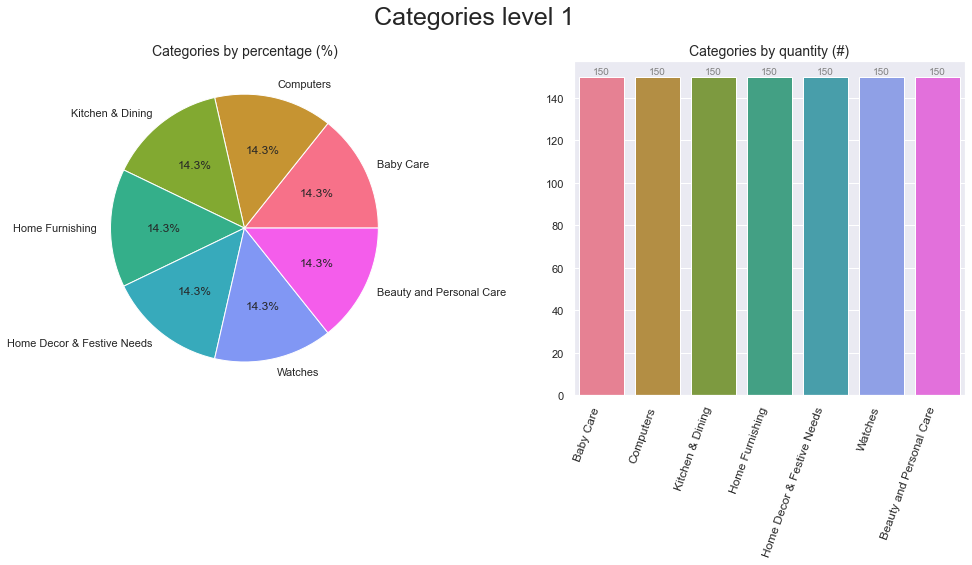

In [26]:
barplot_and_pie(df_data["category_1"], "Categories level 1", "Categories")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the plot, we can ask whether we will get 7 clusters in our modeling? </p>
</div>

<div class="alert alert-block alert-info">
    <p>Let's see the record with <b>retail_price</b> missing-value</p>
</div>

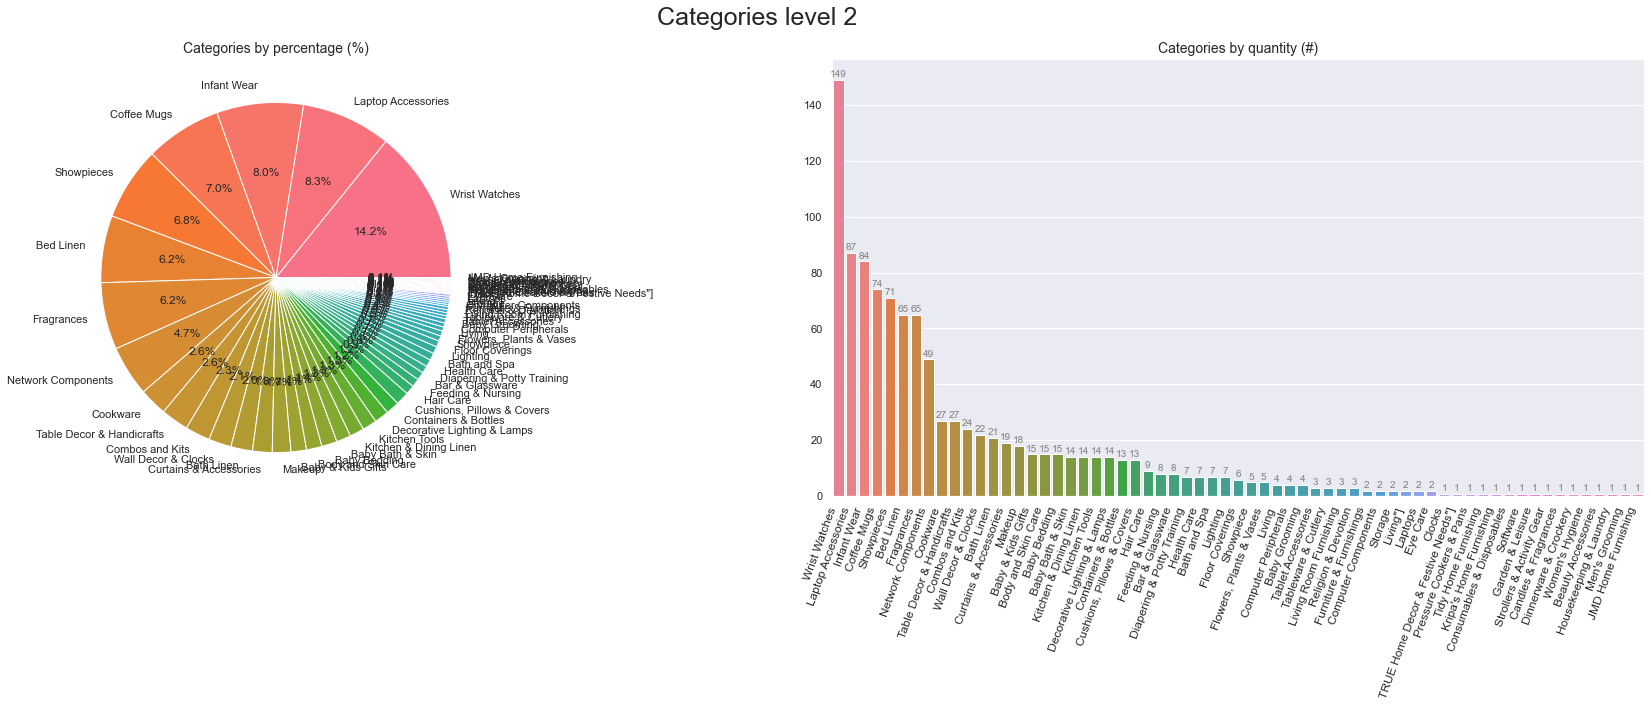

In [27]:
barplot_and_pie(df_data["category_2"], "Categories level 2", "Categories")

In [28]:
df_data[df_data["retail_price"].isna()]

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,tree_levels,category_1,category_2
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",4,Baby Care,Baby Bath & Skin


<div class="alert alert-block alert-success">
    <p>Let's get to the mean of the <b>retail_price</b> based on the firsts two categories in the tree</p>
</div>

In [29]:
retail_price_mean = df_data[(df_data["category_1"]=="Baby Care") & (df_data["category_2"]=="Baby Bath & Skin")]["retail_price"].mean()
retail_price_mean

1200.1538461538462

<div class="alert alert-block alert-info">
    <p>Let's replace the missing-value into <b>retail_price</b></p>
</div>

In [30]:
df_data["retail_price"].fillna(retail_price_mean, inplace=True)

<div class="alert alert-block alert-info">
    <p>Let's proceed to delete the categories features added</p>
</div>

In [31]:
df_data.drop(columns=["tree_levels", "category_1", "category_2"], axis=1, inplace=True)

<div class="alert alert-block alert-info">
    <p>Let's analyze the dataset</p>
</div>

In [32]:
df_analysis(df_data, "df_data", type_analysis="complete")


Analysis Header of df_data dataset
--------------------------------------------------------------------------------
- Dataset shape:			 1050 rows and 8 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 65.8+ KB

Detailed analysis of df_data dataset
------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,uniq_id,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,product_name,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_category_tree,object,1050,642,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,retail_price,float64,1050,355,0,0.00000,2185.25824,35.00000,555.75000,999.00000,1999.00000,201000.00000,7635.64798
4,image,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,description,object,1050,1050,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,brand,object,1050,491,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_specifications,object,1050,985,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we have the dataset without missing-values.</p>
    <p>Let's proced to make the normalization.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Pre-processing Text data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to processing the following features</p>
    <ol>
        <li>product_name</li>
        <li>product_category_tree</li>
        <li>description</li>
        <li>brand</li>
    </ol>
</div>

In [33]:
text_columns = [
    "product_name", "product_category_tree",
    "description", "brand", "product_specifications"
]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing the characters in the features</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Before doing the steps above, let's check what type of character we have in the dataset.<br>Then we can use the appropriate tokenizer</p>
</div>

In [34]:
character_type = ["numerical", "special"]

for col in text_columns:
    
    # checking the character in each sample by feature
    df_data[col + "_check"] = df_data[col].apply(lambda x: check_characters(x))
    
    # Normalizing to column, the dict in the sample
    globals()["df_" + col + "_check"] = pd.json_normalize(df_data[col + "_check"])
    
    # Counting the characters uniques by feature
    for val in character_type:
        globals()["dict_" + col + "_" + val] = {}

        for i in globals()["df_" + col + "_check"][val]:
            for j in i:
                if j not in globals()["dict_" + col + "_" + val]:
                    globals()["dict_" + col + "_" + val][j] = 1
                else:
                    globals()["dict_" + col + "_" + val][j] += 1
                    
        # Sorting dict by value descending
        globals()["dict_" + col + "_" + val] = sorted(globals()["dict_" + col + "_" + val].items(),
                                                      key=operator.itemgetter(1), reverse=True)
        globals()["dict_" + col + "_" + val] = {k:v for k, v in globals()["dict_" + col + "_" + val]}
        
        # Creating dataset based on the dict
        if val == "special":
            globals()["df_" + col + "_" + val] = pd.DataFrame({"character" : list(globals()["dict_" + col + "_" + val].keys()),
                                                              "number" : list(globals()["dict_" + col + "_" + val].values())})

<div class="alert alert-block alert-info">
    <p>Plotting the special characters in <b>description</b></p>
</div>

C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


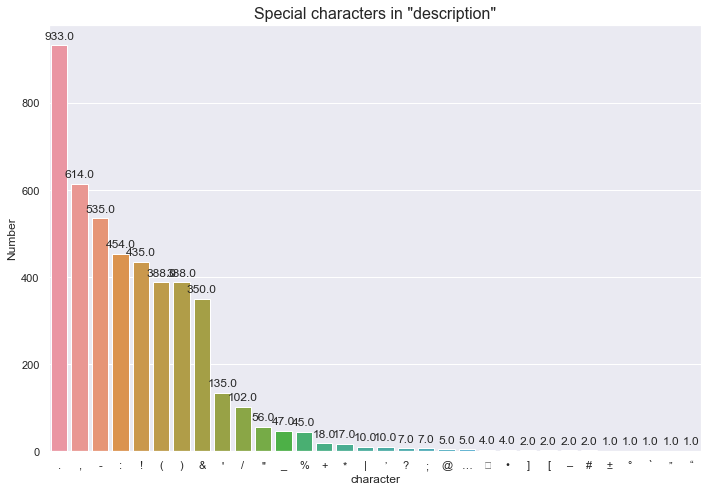

In [35]:
fig = plt.figure(figsize=(10, 7))
plot = sns.barplot(x=df_description_special["character"], y=df_description_special["number"])
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.ylabel("Number", size=12)
plt.xlabel("character", size=12)
plt.title("Special characters in \"description\"", size=16)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the special characters in <b>product_category_tree</b></p>
</div>

C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


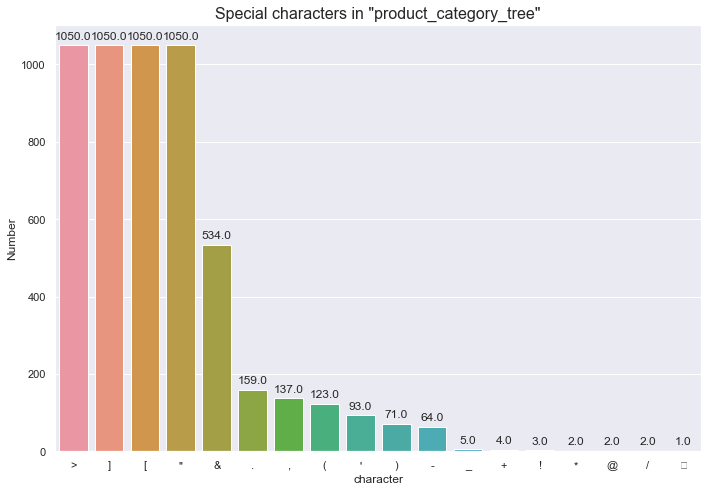

In [36]:
fig = plt.figure(figsize=(10, 7))
plot = sns.barplot(x=df_product_category_tree_special["character"], y=df_product_category_tree_special["number"])
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.ylabel("Number", size=12)
plt.xlabel("character", size=12)
plt.title("Special characters in \"product_category_tree\"", size=16)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the special characters in <b>product_specifications</b></p>
</div>

C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Samir\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


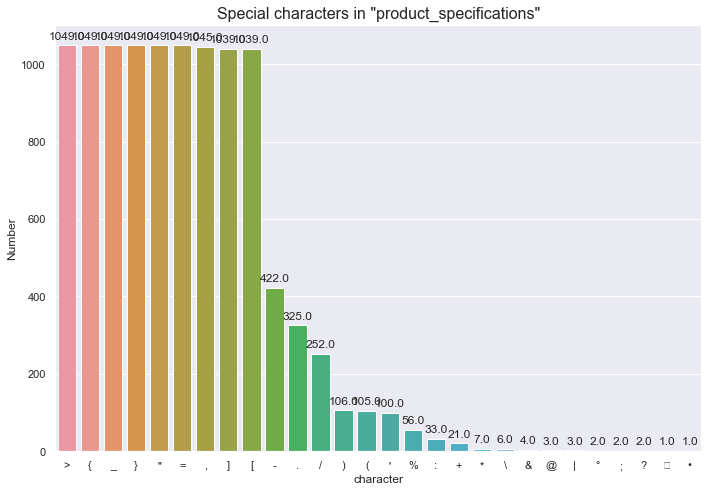

In [37]:
fig = plt.figure(figsize=(10, 7))
plot = sns.barplot(x=df_product_specifications_special["character"], y=df_product_specifications_special["number"])
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.ylabel("Number", size=12)
plt.xlabel("character", size=12)
plt.title("Special characters in \"product_specifications\"", size=16)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <p>Printing the digit characters in <b>product_name</b>, <b>product_category_tree</b>, <b>description</b>, <b>brand</b></p>
</div>

In [38]:
for col in text_columns:
    print(col + " has " + str(len(globals()["dict_" + col + "_numerical"])) + " digit used")

product_name has 10 digit used
product_category_tree has 10 digit used
description has 10 digit used
brand has 8 digit used
product_specifications has 10 digit used


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>The 4 features have used numerical characters.</li>
        <li>It seems there are contractions in the text so, it is necessary to check this point.</li>
    </ul>
</div>

<div class="alert alert-block alert-info">
    <p>Deleting the datasets</p>
</div>

In [39]:
for col in text_columns:
    
    del globals()["df_" + col + "_check"]
    del globals()["df_" + col + "_special"]
    
    del df_data[col + "_check"]
        
    gc.collect()

In [40]:
df_data.head()

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",1899.000000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",600.000000,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",1200.153846,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2699.000000,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2599.000000,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.1.1. Checking contractions</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's check some contractions in the description</p>
</div>

In [41]:
characters_to_check = ["\'re", "\'d", "\'t"]

In [42]:
df_check_characters = df_data[["description"]].copy()

In [43]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [44]:
df_check_characters[df_check_characters["description"].str.contains("|".join(characters_to_check))].tail()

,description
171,Buy Prithish We're All Mad Here Ceramic Mug for Rs.175 online. Prithish We're All Mad Here Ceramic Mug at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
187,"Prithish Wild And Free Ceramic Mug (330 ml)\r\n Price: Rs. 175\r\n\t\t\t\t\r\n\t\t\t""Get talking with your coffee! Our wide selection of cute and catchy designs means you're sure to find the quote that says what it is, the way it is. And if these mugs bring on the smiles, don't forget to share them. Mugs like these make great gifts! Each mug is beautifully designed with quality ink and attractive graphics, perfect for all around enjoyment."" ""Express yourself! Our distinctive coffee mugs give you the freedom to broadcast your own special message, from holiday cheer to your love of cupcakes. These affordable mugs are also perfect for gifting, so you can show others just how well you know them. Break out the mugs, and bring on the laughs! Happy sipping!\r\n""Get talking with your coffee! Our wide selection of cute and catchy designs means you're sure to find the quote that says what it is, the way it is. And if these mugs bring on the smiles, don't forget to share them. Mugs like these make great gifts! Each mug is beautifully designed with quality ink and attractive graphics, perfect for all around enjoyment."" ""Express yourself! Our distinctive coffee mugs give you the freedom to broadcast your own special message, from holiday cheer to your love of cupcakes. These affordable mugs are also perfect for gifting, so you can show others just how well you know them. Break out the mugs, and bring on the laughs! Happy sipping!"
917,"Megaway 196.85 inch White Rice Lights (Pack of 5)\r\n Price: Rs. 4,050\r\n\t\t\t\t\r\n\t\t\tWarning: Don't Direct Plug into AC Power Supply, Use 12V LED Adaptor provided along with the Strip Light. Warranty for Adaptor is for 6 months only.\r\nWarning: Don't Direct Plug into AC Power Supply, Use 12V LED Adaptor provided along with the Strip Light. Warranty for Adaptor is for 6 months only."
966,"Checkered Chef Steel All-Purpose Scissor (Red, Black, Silver, Pack of 1) Price: Rs. 1,921 YOUR SEARCH IS OVER YOU HAVE FINALLY FOUND THE ONLY PAIR OF MULTIFUNCTION KITCHEN SCISSORS YOU WILL EVER NEED - Tackle any kitchen cutting job - fresh chicken, cooked chicken, herbs, meat, vegetables, bones, ribs and cardboard. - Razor sharp stainless steel blades enable you to cut virtually anything with ease! - No more aching fingers! Soft rubberized handles and quality precision workmanship make cutting a breeze! Easy To Clean And Safe Too! Everyone knows that kitchen scissors that don't come apart pose a health risk - they just can't be cleaned properly! But scissors that come apart too easily are annoying and dangerous! Checkered Chef Multifunction Kitchen Scissors are specially designed to only come apart when opened all the way to 90 degrees - wider than the normal cutting range. So you can use your scissors, and clean them too! What About All The Special Features? - Not just a pair of scissors - this is a multifunction kitchen tool! Use as a bottle opener, fish scaler, knife or even a screwdriver! - Our super strong magnetic sheath will keep your scissors safe and within reach at all times - never lose your scissors again! - You've never made a salad this easily - simply cut the lettuce and vegetables straight into the bowl! Are these really the best scissors you can buy? See the boy on our label? That's me - the ""Checkered Chef"". I like to cook and I like to wear checks, that's why they call me the Checkered Chef. I have tested every sample and proto-type that has crossed our kitchen bench. I proclaim these scissors quite simply, the best! Order today by clicking the ""Add to Cart"" tab, check them out for yourself and tell me what you think!,Specifications of Checkered Chef Steel All-Purpose Scissor (Red, Black, Silver, Pack of 1) General Brand Checkered Chef Handle Material Plastic 

In [45]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div class="alert alert-block alert-info">
    <p>Deleting the dataset</p>
</div>

In [46]:
del df_check_characters
gc.collect()

34

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we can see in the text:</p>
    <ul style="list-style-type: square;">
        <li>Characters for new line, tabs, etc..</li>
        <li>There are contractions in the descriptions.</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Tokenization</h3>
</div>

<div class="alert alert-block alert-info">
    <p>To tokenize the text, we are going to do the following</p>
    <ul style="list-style-type: square;">
        <li>Cleaning up the text</li>
        <li>Remove stop words</li>
    </ul>
    <p>Finally, we are going to compare the results</p>
</div>    
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2.2. Cleaning up the text</h4>
</div>

<div class="alert alert-block alert-info">
    <p>To clean up the text, we are going to remove the following</p>
    <ul style="list-style-type: square;">
        <li>Newlines, tabs, etc.</li>
        <li>HTML tags</li>
        <li>Extra whitespace</li>
        <li>Emails</li>
        <li>Accented characters</li>
        <li>Incorrect characters</li>
        <li>Punctuations</li>
        <li>Non alphabet characters</li>
    </ul>
    <p>Also, we are going to do: </p>
    <ul style="list-style-type: square;">
        <li>To transform to lowercase.</li>
        <li>To expand contractions</li>
    </ul>
</div>    
</div>

<div class="alert alert-block alert-info">
    <p>Reading a english contractions dictionay</p>
</div>

In [47]:
file = open("datasets\english_contractions.txt")
contents = file.read()
english_contractions = ast.literal_eval(contents)
file.close()

<div class="alert alert-block alert-info">
    <p>Let's cleaning the features</p>
</div>

In [55]:
initial_tokens_by_feature, cleaned_words_by_feature = [{} for i in range(2)]
for col in text_columns:
    
    # Tokenization of text without clean
    df_data[col + "_initial"] = df_data[col].apply(lambda x: tokenizer(x))
    initial_tokens_by_feature[col] = df_data[col + "_initial"].explode().dropna().value_counts().shape[0]
    del df_data[col + "_initial"]
    
    # Tokenization of text after cleanning
    if col == "product_specifications":
        df_data[col + "_cleaned"] = df_data[col].apply(lambda x: cleaning_up_product_specifications(x))
        df_data[col + "_cleaned"] = df_data[col + "_cleaned"].apply(lambda x: cleaning_up_product_specifications(x))
    else:    
        df_data[col + "_cleaned"] = df_data[col].apply(lambda x: cleaning_up_text(x, english_contractions))
    
    cleaned_words_by_feature[col] = df_data[col + "_cleaned"].explode().dropna().value_counts().shape[0]
    
    
# Sorting dict by value desc
initial_tokens_by_feature = sorted(initial_tokens_by_feature.items(), key=operator.itemgetter(1), reverse=True)
initial_tokens_by_feature = {k:v for k, v in initial_tokens_by_feature}

cleaned_words_by_feature = sorted(cleaned_words_by_feature.items(), key=operator.itemgetter(1), reverse=True)
cleaned_words_by_feature = {k:v for k, v in cleaned_words_by_feature}

In [56]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [57]:
df_data.head(1)

,uniq_id,product_name,product_category_tree,retail_price,image,description,brand,product_specifications,product_name_cleaned,product_category_tree_cleaned,description_cleaned,brand_cleaned,product_specifications_cleaned
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",1899.00000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}","[elegance, polyester, multicolor, abstract, eyelet, door, curtain]","[home, furnishing, curtains, accessories, curtains, elegance, polyester, multicolor, abstract, eyelet, do]","[key, features, of, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, in, height, pack, of, price, rs, this, curtain, enhances, the, look, of, the, interiors, this, curtain, is, made, from, high, quality, polyester, fabric, it, features, an, eyelet, style, stitch, with, metal, ring, it, makes, the, room, environment, romantic, and, loving, this, curtain, is, ant, wrinkle, and, anti, shrinkage, and, have, elegant, apparance, give, your, home, a, bright, and, modernistic, appeal, with, these, designs, the, surreal, attention, is, sure, to, steal, hearts, these, contemporary, eyelet, and, valance, curtains, slide, smoothly, so, ...]",[elegance],


In [54]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div style="background-color: #FF5733;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">--------- FLAG POSITION ---------</h1>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div style="background-color: #FF5733;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">--------- FLAG POSITION ---------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2.2. Removing words</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to reduce words based on the following:</p>
    <ul style="list-style-type: square;">
        <li>Stop words</li>
        <li>Non english words</li>
        <li>Keep Nouns</li>
    </ul>    
    <p>It must consider that the mission is not about sentiment analysis, it is about classification</p>
</div>

In [ ]:
reduced_words_by_feature = {}
for col in text_columns:
    df_data[col + "_tokens"] = df_data[col + "_cleaned"].apply(lambda x: remove_words(x, "english"))
    reduced_words_by_feature[col] = df_data[col + "_tokens"].explode().dropna().value_counts().shape[0]

    del df_data[col + "_cleaned"]
    
# Sorting dict by value descending
reduced_words_by_feature = sorted(reduced_words_by_feature.items(), key=operator.itemgetter(1), reverse=True)
reduced_words_by_feature = {k:v for k, v in reduced_words_by_feature}

In [ ]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [ ]:
df_data.head(1)

In [ ]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2.3. Compare the results</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's compare the number of words during the all process</p>
</div>

In [ ]:
fig = plt.figure(figsize=(15, 4))

# Plot the total words tokenized
sns.set_color_codes("pastel")
plot = sns.barplot(x=list(initial_tokens_by_feature.values()),
                   y=list(initial_tokens_by_feature.keys()), 
                   label="Initial", color="b")

# Plot the words tokenized after cleanning up
sns.set_color_codes("muted")
plot = sns.barplot(x=list(cleaned_words_by_feature.values()),
                   y=list(cleaned_words_by_feature.keys()),
                   label="Intermediate", color="b")

# Plot the words tokenized after reducing stop words
sns.set_color_codes("dark")
plot = sns.barplot(x=list(reduced_words_by_feature.values()),
                   y=list(reduced_words_by_feature.keys()),
                   label="Final", color="b")

plt.legend(ncol=3, loc="lower right", frameon=True)
plt.xlabel("Numbers of tokens", size=12)
plt.ylabel("Features", size=12)
plt.title("Number of tokens during all process", size=16)
plt.tight_layout()
plt.savefig("images/text_analysis/number-of-tokens-during-process.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Here, we can see how the tokens have reduced during all process, being description the features with more tokens during the process</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Stemming the tokens</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We use <b>Porter stemming algorithm</b> because it has a less agressive approach in comparison with <b>PLancaster stemming algorithm</b></p>
</div>

In [ ]:
for col in text_columns:
    df_data[col + "_stemmed"] = df_data[col + "_tokens"].apply(lambda x: stem_words(x))

In [ ]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [ ]:
df_data[["description", "description_tokens", "description_stemmed"]].head(3)

In [ ]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Lemmatization the tokens</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We use <b>Porter stemming algorithm</b> because it has a less agressive approach in comparison with <b>PLancaster stemming algorithm</b></p>
</div>

In [ ]:
for col in text_columns:
    df_data[col + "_lemma"] = df_data[col + "_tokens"].apply(lambda x: lemma_words(x))

In [ ]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [ ]:
df_data[["description", "description_tokens", "description_stemmed", "description_lemma"]].head(2)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we can see an example of text after doing all process</p>
    <p>It seems that the lemmatization have got better results than stemming</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Text Vectorization</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's see all features transformed</p>
</div>

In [ ]:
for col in text_columns:
    
    if col == "description":
        head = 2
    else:
        head = 5
    
    print("-"*200)
    print(" >> " + col)
    display(df_data[[col, col + "_tokens", col + "_stemmed", col + "_lemma"]].head(head))
    print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we can see how the features have been transformed</p>
</div>

In [ ]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Thresholds lower frequency</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Before doing the <b>Text Vectorization</b>, let's analyse the number of words with lower frequency in each feature, to define the threshold (min_df) to tream them </p>
    <p>To do that we are going to use BoW in default mode and plot the numbers of words with lower frequency</p>
</div>

In [ ]:
cv_vectorizer = CountVectorizer()

In [ ]:
for col in text_columns:
    
    for var in ["stemmed", "lemma"]:
        
        globals()["bow_" + col + "_" + var] = cv_vectorizer.fit_transform(df_data[col + "_" + var].astype("U"))
        globals()["df_bow_" + col + "_" + var] = pd.DataFrame(globals()["bow_" + col + "_" + var].toarray(),
                                                              columns=cv_vectorizer.get_feature_names())
        
        if var == "stemmed":
            palette = "flare"
        else:
            palette = "crest"
        
        # Plottint the results
        most_frequent_words = (globals()["df_bow_" + col + "_" + var].sum(axis=0)).sort_values(ascending=True)
        globals()["df_lower_frequent_words_" + col + "_" + var] = pd.DataFrame.from_dict({"words" : most_frequent_words.index,
                                                                                          "frequency" : most_frequent_words.values})

        lower_frequent_words = globals()["df_lower_frequent_words_" + col + "_" + var].groupby("frequency")["frequency"].count().head(30)

        fig = plt.figure(figsize=(15, 5))
        plot = sns.barplot(x=lower_frequent_words.index, y=lower_frequent_words, palette=palette)
        for p in plot.patches:
            plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha="center", va="center", xytext=(0, 9), textcoords="offset points")
        plot.set_xticklabels(labels=lower_frequent_words.index, rotation=70, size=12,
                                 horizontalalignment="right")
        plt.ylabel("Number of words", size=12)
        plt.xlabel("Frequency", size=12)
        plt.title("Numbers of words by frequency\n(" + col + " - " + var + ")", size=16)
        plt.tight_layout()
        plt.show()
            
    print("\n\n")


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Now, we are going to define the following thresholds (min_df)</p>
    <ul style="list-style-type: square;">
        <li>product_name: min_df=3</li>
        <li>product_category_tree: min_df=3</li>
        <li>description: min_df=5</li>
        <li>brand: min_df=2</li>
    </ul>  
</div>

In [ ]:
text_columns = {
    "product_name": 3,
    "product_category_tree": 3,
    "description": 5,
    "brand": 2    
}

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Bag of Word - BoW</h3>
</div>

In [ ]:
pd.set_option("display.max_columns", 25) # show full of showing cols

<div class="alert alert-block alert-info">
    <p>Now, we are going to do a BoW for each feature, considering the stemmed and lemma treatments</p>
    <p>Let's initialize the CountVectorizer based on the min_df defined</p>
</div>

In [ ]:
for key, value in text_columns.items():
    
    # Initializing the CountVectorizer based on the min_df defined previously
    cv_vectorizer = CountVectorizer(min_df=value)
    
    for var in ["stemmed", "lemma"]:
        
        globals()["bow_" + key + "_" + var] = cv_vectorizer.fit_transform(df_data[key + "_" + var].astype("U"))
        globals()["df_bow_" + key + "_" + var] = pd.DataFrame(globals()["bow_" + key + "_" + var].toarray(),
                                                              columns=cv_vectorizer.get_feature_names())

<div class="alert alert-block alert-info">
    <p>Printing some resultants datasets</p>
</div>

In [ ]:
print("-"*120)
print(" >> product_name_stemmed")
display(df_bow_product_name_stemmed.head())
print(" >> product_name_lemma")
display(df_bow_product_name_lemma.head())
print("\n")
print("-"*120)
print(" >> description_stemmed")
display(df_bow_description_stemmed.head())
print(" >> description_lemma")
display(df_bow_description_lemma.head())

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Term Frequency - TF-IDF</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to do a TF-IDF for each feature, considering the stemmed and lemma treatments</p>
    <p>Let's initialize the TfidfVectorizer based on the min_df defined</p>
</div>

In [ ]:
for key, value in text_columns.items():
    
    # Initializing the TfidfVectorizer based on the min_df defined previously
    tfidf_vectorizer = TfidfVectorizer(min_df=value)
    
    for var in ["stemmed", "lemma"]:
        
        globals()["tfidf_" + key + "_" + var] = tfidf_vectorizer.fit_transform(df_data[key + "_" + var].astype("U"))
        globals()["df_tfidf_" + key + "_" + var] = pd.DataFrame(globals()["tfidf_" + key + "_" + var].toarray(),
                                                                columns=tfidf_vectorizer.get_feature_names())

<div class="alert alert-block alert-info">
    <p>Printing some resultants datasets</p>
</div>

In [ ]:
print("-"*120)
print(" >> product_name_stemmed")
display(df_tfidf_product_name_stemmed.head())
print(" >> product_name_lemma")
display(df_tfidf_product_name_lemma.head())
print("\n")
print("-"*120)
print(" >> description_stemmed")
display(df_tfidf_description_stemmed.head())
print(" >> description_lemma")
display(df_tfidf_description_lemma.head())

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Compare the results</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's compare the words most frequents based on BoW and TI-IDF</p>
</div>

In [ ]:
for col, value in text_columns.items():
    
    for var in ["stemmed", "lemma"]:
        
        for type_of_vector in ["bow", "tfidf"]:
            
            if type_of_vector == "bow":
                palette = "flare"
                temp = "BoW"
            else:
                palette = "crest"
                temp = "TF-IDF"
        
             # Plottint the results
            most_frequent_words = (globals()["df_" + type_of_vector + "_" + col + "_" + var].sum(axis=0)).sort_values(ascending=False).head(30)

            fig = plt.figure(figsize=(15, 5))
            plot = sns.barplot(x=most_frequent_words.index, y=most_frequent_words, palette=palette)
            plot.set_xticklabels(labels=most_frequent_words.index, rotation=70, size=12,
                                     horizontalalignment="right")
            plt.ylabel("count", size=12)
            plt.xlabel("words", size=12)
            plt.title("The 30 words most frequents words in \"" + col + "\" - \"" + var + "\"\n" + temp, size=16)
            plt.tight_layout()
            plt.show()
            
        print("\n\n")

<div style="background-color: #FF5733;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">--------- FLAG POSITION ---------</h1>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div style="background-color: #FF5733;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">--------- FLAG POSITION ---------</h1>
</div>

enlaces 

- https://www.youtube.com/watch?app=desktop&v=1yEwwUasWTY
- https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne.
- https://www.youtube.com/watch?v=gQddtTdmG_8
- https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8
- https://www.youtube.com/watch?v=T05t-SqKArY
- https://stackoverflow.com/questions/64474059/how-to-use-sift-and-surf-algorithm-in-google-colab-with-opencv4
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
- https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99
- https://distill.pub/2016/misread-tsne/
- http://www.gwylab.com/download/ORB_2012.pdf
- https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing/6532308-build-your-first-word-cloud
- https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
- https://www.kaggle.com/tanguypledel/topic-modeling-lda-implementation